In [ ]:
import pandas as pd
from PIL import Image
import numpy as np

#Этап 1
Получаем данные из csv файла и проводим необходимые преобразования над данными в таблице

In [ ]:
log = pd.read_csv('/content/drive/MyDrive/CourseProject/Test_1/helpdesk.csv', sep=',')
log["CaseID"]=log["CaseID"].apply(str)
log["ActivityID"]=log["ActivityID"].apply(str)
log['CompleteTimestamp']= pd.to_datetime(log['CompleteTimestamp'])

Заголовок журнала событий

In [ ]:
log.head()

,CaseID,ActivityID,CompleteTimestamp
0,2,1,2012-04-03 16:55:38
1,2,8,2012-04-03 16:55:53
2,2,6,2012-04-05 17:15:52
3,3,1,2010-10-29 18:14:06
4,3,8,2010-11-04 01:16:11


Получаем уникальные активити и проводим соответствие между активностью и целым числом

In [ ]:
# получаем уникальные активити
activities = list(log['ActivityID'].unique())
act_dict = {}

# проводим типо изоморфизм между номером и активити
act_num = len(activities)
for i in range(act_num):
  act_dict[activities[i]] = i

#Этап 2
Выделяем из лога отдельную трассу с case ID == 26


In [ ]:
event_log = log[['ActivityID', 'CaseID', 'CompleteTimestamp']].copy()
trace = event_log.query("CaseID == '26'")
trace.sort_values(by=['CompleteTimestamp'])

,ActivityID,CaseID,CompleteTimestamp
56,1,26,2011-03-31 15:28:47
57,8,26,2011-03-31 15:31:59
58,9,26,2011-03-31 16:39:41
59,8,26,2011-03-31 19:00:28
60,6,26,2011-03-31 19:00:41


Получаем префиксные трассы по трассе и записываем их в контейнер

In [ ]:
prefix_traces_act = []

for i in range(1, len(trace)+1):
  prefix_traces_act.append( trace['ActivityID'].values[0:i] )

prefix_trace_num = len(prefix_traces_act)

prefix_traces_act

[array(['1'], dtype=object),
 array(['1', '8'], dtype=object),
 array(['1', '8', '9'], dtype=object),
 array(['1', '8', '9', '8'], dtype=object),
 array(['1', '8', '9', '8', '6'], dtype=object)]

Получаем матрицу по каналу Activity

Процесс построение префиксной трассы: Пусть есть множество активностей |{R, RR, CT, ET, D, AR}| = k и в логе есть трасса |<R, ET, CT, ET, CT, D, RR>| = n = 7. Тогда могут быть построенные 7  префиксных трасс = {<R>; <R, ET>; <R, ET, CT>; <R, ET, CT, ET>; <R, ET, CT, ET, CT>; <R, ET, CT, ET, CT, D>;  <R, ET, CT, ET, CT, D, RR> }. Далее мы получаем матрицу размера n*k где в позиции ij записано количество раз которое встречалось j-ая активность на момент префиксной трассы i.

In [ ]:
# Получаем матрицу по каналу activity

trace_len = len(trace)
matrix = [ [0]*act_num for i in range(trace_len)]


for i in range(prefix_trace_num):
  for act in prefix_traces_act[i]:
    act_index = act_dict[act]
    matrix[i][act_index] += 1

matrix

[[1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 0, 0, 0, 0],
 [1, 2, 0, 0, 1, 0, 0, 0, 0],
 [1, 2, 1, 0, 1, 0, 0, 0, 0]]

#Этап 3

Строим изображение по матрице канала Activity

Здесь мы нормализуем матрицу, то есть переводим её значения в шкалу от 0 до 255.
И далее, при помощи библиотека PIL преобразуем матрицу в изображение.

[[127   0   0   0   0   0   0   0   0]
 [127 127   0   0   0   0   0   0   0]
 [127 127   0   0 127   0   0   0   0]
 [127 255   0   0 127   0   0   0   0]
 [127 255 127   0 127   0   0   0   0]]


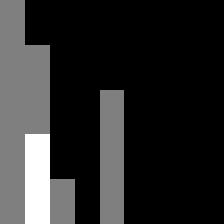

In [ ]:
np_matrix = np.asmatrix(matrix)
np_matrix = np_matrix.astype("uint8")
norm_matrix = np_matrix.copy()
norm_matrix *= 255.0/norm_matrix.max()
print(norm_matrix)
A = np.squeeze(np.asarray(norm_matrix)) 
img = Image.fromarray(A)

#VGG model expects the images it receives to be 224x224 NumPy arrays
img = img.resize((224, 224),Image.NEAREST)
img